In [83]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import norm
import torch
import matplotlib.pyplot as plt

In [85]:
from utils.probs import *

In [2]:
path = Path('../dataset/')

In [3]:
DATA = path/'probabilities'

In [4]:
df = pd.read_csv(DATA/'RF_probabilityfunction1.csv')

In [5]:
df.head()

,w,p,mu,sigma
0,0.000223,0.000625,3.754835,1.312323
1,0.000222,0.001049,3.706937,1.309473
2,0.000221,0.001267,3.656876,1.332337
3,0.000220,0.000935,3.667281,1.309200
4,0.000219,0.000791,3.712052,1.263111


In [6]:
df_output = pd.read_csv(DATA/'modCHEMBL205_predictions_RF.csv')

In [7]:
df_output.head()

,class,prediction,predicted_class,prediction_int,prediction_lnodds
0,0,0.975,0,195,3.644701
1,0,0.990,0,198,4.547894
2,0,0.950,0,190,2.935226
3,0,0.995,0,199,5.200532
4,1,0.105,1,21,-2.138765


In [8]:
df_output = df_output.prediction
df_output.head()

0    0.975
1    0.990
2    0.950
3    0.995
4    0.105
Name: prediction, dtype: float64

In [9]:
preds = df_output.to_numpy()

In [10]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.915, 0.99 , 0.3  ])

In [11]:
def direct_prob(x, cl, w, p, m, s):
    """
    Gives probability of class conditional on RF-output
    x = RF output (between 0 and 1)
    cl = class (0 or 1)
    w = array of weights
    p = array of probs
    m = array of means for gaussian
    s = array of standard devs for gaussian
    """
    cl = cl
    c = 1 - 2**-10
    x2 = 0.5 + (x-0.5) * c
    y = np.log(x2/(1-x2))
    pc = p*cl + (1-p) * (1-cl)
    pjoint = np.sum(pc * w * norm.pdf(y, loc=m, scale=s))
    px = np.sum(w * norm.pdf(y, loc=m, scale=s))
    out = pjoint / px
    return out

In [23]:
mu = df.mu.to_numpy()
sigma = df.sigma.to_numpy()
p = df.p.to_numpy()
w = df.w.to_numpy()

In [24]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.915, 0.99 , 0.3  ])

In [75]:
all_probs_0 = np.array([])
for pred in preds:
    prob = direct_prob(pred, 0, w, p, mu, sigma)
    all_probs_0 = np.append(all_probs_0, prob)
all_probs_0

array([0.99784844, 0.99832858, 0.99593276, ..., 0.98883941, 0.99832858,
       0.11968487])

In [76]:
all_probs_1 = np.array([])
for pred in preds:
    prob = direct_prob(pred, 1, w, p, mu, sigma)
    all_probs_1 = np.append(all_probs_1, prob)
all_probs_1

array([0.00215156, 0.00167142, 0.00406724, ..., 0.01116059, 0.00167142,
       0.88031513])

In [77]:
df_all = pd.DataFrame()
df_all['preds'] = preds
df_all['probs_class_0'] = all_probs_0
df_all['probs_class_1'] = all_probs_1
df_all

,preds,probs_class_0,probs_class_1
0,0.975,0.997848,0.002152
1,0.990,0.998329,0.001671
2,0.950,0.995933,0.004067
3,0.995,0.998112,0.001888
4,0.105,0.092222,0.907778
...,...,...,...
3583,0.150,0.096281,0.903719
3584,0.995,0.998112,0.001888
3585,0.915,0.988839,0.011161
3586,0.990,0.998329,0.001671


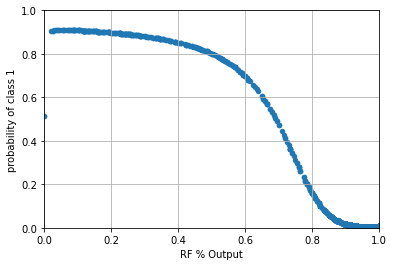

In [74]:
df_all.plot.scatter(x='preds', y='probs')
plt.xlabel('RF % Output')
plt.ylabel('probability of class 1')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()


plt.savefig('../dataset/RF_output.png')
plt.show()

In [79]:
df_all.to_csv(DATA/'RF_probabilities.csv')